
# Acoustics equations

This notebook illustrates some features of the exact solution to the 1-dimensional constant coefficient acoustics equations, as described in more detail in Chapter 3 of <cite data-cite="fvmhp"><a href="riemann.html#fvmhp">(LeVeque 2002)<a></cite>. Since acoustic equations are a landmark example of linear wave propagation, we will begin with a brief derivation of the equations. This will also help having a self contained document. 

## Brief derivation of linear acoustics equations
The linear acoustic equations can be obtained by linearizing the conservation of mass and momentum for an element of fluid. The conservation of mass and momentum for a fluid element are given by
fo
\begin{align*}
\frac{\partial \rho}{\partial t} + \nabla \cdot \left(\rho \bar{u}\right) = 0 \\
\frac{d \rho \bar{u}}{dt} = -\nabla P
\end{align*}

where $d/dt$ denotes the material derivative: $\frac{d}{dt} = \frac{\partial}{\partial t} + \bar{u} \cdot \nabla $. In one dimension, these can be easily rewritten as,

\begin{align*}
\rho_t + (\rho u)_x = 0, \\
(\rho u)_t + (\rho u^2 + P(\rho))_x =0,
\end{align*}

where we assumed the pressure is a function of the density, which is only accurate for small perturbations
around some equilibrium state given by $\rho_0$ and $u_0$. Linearizing the equation around $\rho_0$ and $u_0 =0$, we obtain a simpler system for the perturbations,

\begin{align*}
\rho_t + (\rho u)_x = 0, \\
(\rho u)_t + P(\rho_0)\rho_x =0.
\end{align*}

where, somewhat abusing the notation, $\rho$ and $u$ are now the perturbations around $\rho_0$ and $u_0 = 0$. As perturbations on the pressure and density satisfy, 

\begin{align*}
p\approx P'(\rho_0)\rho, \\
\rho u \approx \rho_0 u,
\end{align*}

we can rewrite the system of linear acoustic equations as

\begin{align*}
 \left[ \begin{array}{c}
p \\
u 
\end{array} \right]_t
+  \underbrace{\left[ \begin{array}{cc}
0 & K_0 \\
1/\rho_0 & 0  \\
\end{array} \right]}_{\mathbf{A}}
\left[ \begin{array}{c}
p \\
u \end{array} \right]_x = 0,
\end{align*}

with $K_0=\rho_0 P'(\rho_0)$ the bulk modulus of compressibility for the media where the waves are propagating. It tells us how compressible is a material; a higher value implies less compressibility. The speed of sound in a given medium can be obtained in terms of the density and bulk modulus following the Newton-Laplace equation

\begin{align*}
c = \sqrt{\frac{K}{\rho}},
\end{align*}

which is consistent with the classical mechanics general equation to obtain the speed of sound from a general equation of state, $c=\sqrt{(\partial P)/\partial \rho)_s}$.

## Exact solver

In a more general framework, acoustic equations are a linear hyperbolic system of two equations for $q = [p, u]^T$, where $p$ is the pressure perturbation and $u$ is the velocity. As we just derived, the system is $q_t + Aq_x = 0$, where the coefficient matrix is

\begin{align*}
A = \left[\begin{array}{cc}0&K\\1/\rho&0\end{array}\right], 
\end{align*}

where $\rho$ is the density and $K$ the bulk modulus (note we dropped the subscripts for simplicity). The sound speed and acoustic impedance are given by $c = \sqrt{K/\rho}$ and $Z=\rho c=$, respectively. The impedance can be understood as the resitance of the medium to the propagation of acoustic waves. In order to solve the Riemann problem, we would like to solve this system subject to the initial condition on $q(x,t)$,

\begin{align*}
q(x,0) = \begin{cases}
q_\ell & \text{if   } x \le 0, \\
q_r & \text{if   } x > 0.
\end{cases}
\end{align*}

The solution can be obtained by transforming the linear system into two uncoupled advection equations, see <cite data-cite="fvmhp"><a href="riemann.html#fvmhp">(LeVeque 2002)<a></cite>. When transformed back to the original coordinates the solution will have the following structure, 

<img style="float: center" src="figures/acoustics_xt_plane.png" width="300">

The structure in the $x-t$ plane shows two waves propagating at velocities $s_1=-c$ and $s_2=c$, which correspond to the two eigenvalues of $A$. At time zero the initial condition remains true, but at times $t>0$ a third state emerges, $q_m$, and it can be calculated from the eigenvectors of the matrix $A$. The corresponding eigenvectors are

\begin{align*}
r_1 = \left[\begin{array}{c}-Z\\1\end{array}\right], \qquad r_2 = \left[\begin{array}{c}Z\\1\end{array}\right].
\end{align*}

For arbitrary states $q_\ell$ and $q_r$, the Riemann solution consists of two waves propagating with velocities $\pm c$ with an intermediate state $q_m$ that is connected to $q_\ell$ by a multiple of $r_1$ and to $q_r$ by a multiple of $r_2$. Therefore, the left and right states are connected through a linear combination of $r_1$ and $r_2$,

\begin{align*}
q_r-q_\ell = \Delta q = \alpha_1 r_1 + \alpha_2 r_2,
\end{align*}

where $\Delta q = [\Delta p, \Delta u]^T$.
We can write this in more general form form as 
\begin{align*}
R \alpha = \Delta q,
\end{align*}

where $\alpha=[\alpha_1, \alpha_2]^T$ and $R=[r_1,r_2]$ is the matrix of column eigenvectors,

\begin{align*}
R = \left[\begin{array}{cc}-Z& Z\\1 & 1\end{array}\right].
\end{align*}

We can solve this linear system for $\alpha$ to obtain,

\begin{align*}
\alpha_1 = \frac{-\Delta p + Z\Delta u}{2Z}, \ \ \ \ \ \
\alpha_2 = \frac{\Delta p + Z\Delta u}{2Z}.
\end{align*}

We can now obtain the value of $q_m$ in terms of $q_\ell$ or $q_r$

\begin{align*}
q_m = q_\ell + \alpha_1 r_1 = q_r - \alpha_2 r_2.
\end{align*}

## Examples
We will begin by defining a function that calls the exact solver in [exact_solvers/acoustics.py](exact_solvers/acoustics.py) and plots the solution for different interesting examples

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, widgets
from exact_solvers import acoustics, interactive_pplanes
from utils import riemann_tools

In [2]:
def plot_riemann_solution(ql, qr, bulk, rho):
    ex_states, ex_speeds, reval = acoustics.exact_riemann_solution(ql ,qr, bulk, rho)

    plot_function = riemann_tools.make_plot_function(ex_states, ex_speeds, reval, layout='vertical',
                                                    variable_names=['pressure', 'velocity'])

    return interact(plot_function, t=widgets.FloatSlider(value=0.0,min=0,max=1.0));

### Problem1: Shock tube problem:

If the velocity is 0 in both initial states (the shock tube problem) then the resulting Riemann solution consists of pressure jumps of equal magnitude propagating in each direction, with equal and opposite jumps in velocity.

In [11]:
ql = np.array([5,0])
qr = np.array([1,0])
bulk = 4.0
rho = 1.0
plot_riemann_solution(ql, qr, bulk, rho);

#### Plot the particle trajectories

For the acoustics equations, the second component of `q` is the velocity.  By integrating the velocities we can get particle positions.  The following utility function does this for us based on the Riemann solution, solving

$$
X'(t) = u(X(t), t),\qquad \text{for} \quad t \geq 0, \qquad \text{with initial data} ~ X(0) = x_0
$$

for a set of 20 initial particle locations $x_0$ evenly distributed along the x-axis at time $=0$.

Note that the particles initially have velocity 0 and are accelerated to the right by either acoustic wave.  The velocity is constant between the two waves and positive because the pressure chosen was greater to be greater in the left state than in the right state.  If $p_\ell < p_r$ the the fluid would be accelerated to the left instead.

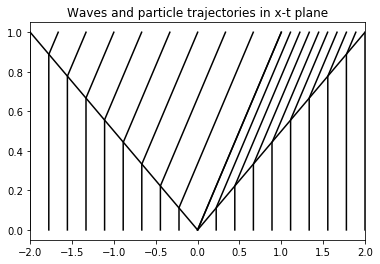

In [12]:
states, speeds, reval = acoustics.exact_riemann_solution(ql ,qr, bulk, rho)
riemann_tools.plot_riemann_trajectories(states,speeds,reval,i_vel=1)
plt.show()

### Problem 2: Flow into a wall:

As another example, suppose the pressure is initially the same in the left and right states, while the velocities are non-zero with $u_r = -u_\ell > 0$.  Particles are converging from both sides and if the initial states have this symmetry, then the result is a middle state $q_m$ in which the velocity is 0 (and the pressure is higher than on either side).

In [5]:
ql = np.array([3,2])  
qr = np.array([3,-2])  
bulk = 20.0
rho = 1.0
plot_riemann_solution(ql, qr, bulk, rho);

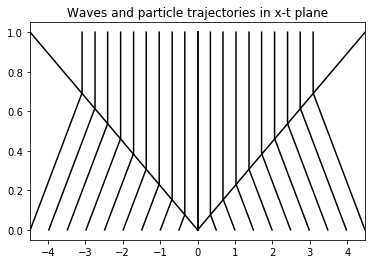

In [6]:
# Plot the particle trajectories
states, speeds, reval = acoustics.exact_riemann_solution(ql ,qr, bulk, rho)
riemann_tools.plot_riemann_trajectories(states,speeds,reval,i_vel=1)
plt.show()

If you discard half the solution (for $x>0$ or for $x<0$) then what you see can be viewed as the solution to a problem with fluid streaming at constant velocity toward a solid wall.  The result is an acoustic wave that moves away from the wall, and the fluid behind the shock has been decelerated to velocity 0, i.e. it is stationary at the wall.

This type of Riemann solution is critical when imposing solid wall boundary conditions in a numerical method. If ghost cells are introduced outside the domain and the state in the ghost cell set by reflecting the interior solution with the symmetry seen here (equal pressure, negated velocity), then the solution to the Riemann problem at the cell interfaces yields a solution that satisfies the desired boundary conditions. 

## Acoustic propagation in heterogenous materials

In theory, we should also be able to model acoustic waves propagation through materials that do not have heterogenous density or bulk modulus, like some layered media or any kind of interface, like walls. In this case, the basic Riemann problem to solve is the acosutic Riemann problem with discontinuous coefficients (discontinuous $\rho$ and $K$). Once this problem is solved it can be used to approximate discretely a continuous denity varying material or other similar examples. The main difference with the previous example is that the value of $\rho$ and $K$ will be different on the left side than on the right side. Therefore, the eigenvalues and eigenvectors are modified as follows. The eigenvalues will be given by the sound speed in each of the two mediums,

\begin{align*}
s_l = -c_l  \ \ \ \ \ s_r = c_r \ \ \ \ \ \mathrm{with:} \ \ \ \ \ c_i = \sqrt{\frac{K_{i}}{\rho_{i}}},
\end{align*}

and the eigenvalues by the impedances of each medium as well, so we can write the matrix of column eigenvectors $R=[r_1, r_2]$ as,

\begin{align*}
R = 
\left[ \begin{array}{ccccc}
-Z_{l} & Z_{r} \\
 1   & 1  \\
\end{array} \right].
\end{align*}

Once again, we onlye need to solve $\mathbf{R} \bar{\alpha} = \Delta \bar{q}$, which yields the values
of $\alpha$

\begin{align*}
\alpha_1 = \frac{-\Delta p + Z_r\Delta u}{Z_l + Z_r}, \ \ \ \ \ \
\alpha_2 = \frac{\Delta p + Z_l\Delta u}{Z_l + Z_r}.
\end{align*}

The middle state is again given simply by $q_m = q_\ell + \alpha_1 r_1 = q_r - \alpha_2 r_2$.


## Examples
We will show some examples of where this Riemann problem becomes relevant. As in the previous case, we will begin by defining a function to do the interactive plotting for the different cases.

In [7]:
def plot_heterogenous_riemann(ql, qr, bulk, rho):
    ex_states, ex_speeds, reval = acoustics.exact_riemann_heterogenous(ql ,qr, bulk, rho)

    plot_function = riemann_tools.make_plot_function(ex_states, ex_speeds, reval, layout='vertical',
                                                    variable_names=['pressure', 'velocity'])

    return interact(plot_function, t=widgets.FloatSlider(value=0.0,min=0,max=1.0));

### Problem 3: Propagation through a wall
In the previous example, we showed the flow into a wall, which basically models the wall as a completely reflective surface. In most cases, this is a good approximation for the reflected waves; however, we could also ask what is the propagated acoustic wave through the wall. We can answer this question by using the air's bulk modulus and density in the right side and the wall's density and bulk modulus on the right. Air actually has density of $\rho \approx 1 kg/m^3$ and $K\approx 100 kPa$, steel on the other hand has $\rho\approx 8000 kg/m^3$ and $K=160 GPa$. Considering the atmospheric pressure to be $p_{atm} = 101325 Pa$, and an acoustic wave hitting the steel at $340 m/s$, we have all the parameters. As expected you will notice the acoustic wave
on the steel propagates extremely faster than in the air, which is around $5000 m/s$, around 14 times faster than in air.

In [8]:
patm = 101325.0
ql = np.array([patm,340])  
qr = np.array([patm,0])  
bulk = [100000.0, 160000000000.0] # left and right bulk modulus
rho = [1.0, 8000.0] # left and right density
plot_heterogenous_riemann(ql, qr, bulk, rho);

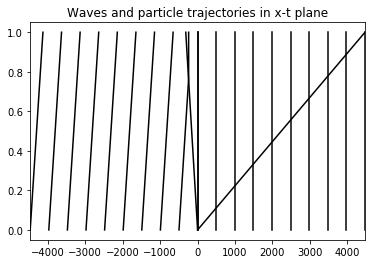

In [9]:
# Plot the particle trajectories
states, speeds, reval = acoustics.exact_riemann_heterogenous(ql ,qr, bulk, rho)
riemann_tools.plot_riemann_trajectories(states,speeds,reval,i_vel=1)
plt.show()

# OLD STUFF
The next cell imports a module containing a function that takes a Riemann problem (left state, right state, and approximate solver), and computes the Riemann solution, as well as functions to plot the solution in various forms.  

In [ ]:
from clawpack.riemann.acoustics_1D_py import acoustics_1D
solver = acoustics_1D

### Set some problem data needed by the solver:

In [ ]:
problem_data = {}

rho = 1.            # density
K = 4.              # bulk modulus
c = np.sqrt(K/rho)  # sound speed
Z = np.sqrt(K*rho)  # impedance

print("Density rho = %g, Bulk modulus K = %g" % (rho,K))
print("Sound speed = %g, Impedance = %g" % (c,Z))

problem_data['zz'] = Z 
problem_data['cc'] = c

### Set the left and right states, and solve the Riemann problem

In [ ]:
q_l = np.array((1,4))  # Left state
q_r = np.array((3,7))  # Right state

states, s, riemann_eval = riemann_tools.riemann_solution(solver,q_l,q_r,\
                                            problem_data=problem_data, verbose=True)

### Plot the states in the phase plane:

In [ ]:
fig = plt.figure(figsize=(4,3))
ax = plt.axes()
riemann_tools.plot_phase(states, ax=ax, label_h='pressure', label_v='velocity')

### Plot the waves in the x-t plane, and the solution at one particular time:

In [ ]:
fig = riemann_tools.plot_riemann(states,s,riemann_eval,t=0.5)

### Animate the Riemann solution:

In [ ]:
riemann_tools.JSAnimate_plot_riemann(states,s,riemann_eval)

### Shock tube problem:

If the velocity is 0 in both initial states (the shock tube problem) then the resulting Riemann solution consists of pressure jumps of equal magnitude propagating in each direction, with equal and opposite jumps in velocity.

In [ ]:
q_l = np.array((5,0))  # Left state
q_r = np.array((4,0))  # Right state

states, s, riemann_eval = riemann_tools.riemann_solution(solver,q_l,q_r,\
                                            problem_data=problem_data, verbose=True)

### Plot the particle trajectories

For the acoustics equations, the second component of `q` is the velocity.  By integrating the velocities we can get particle positions.  The following utility function does this for us based on the Riemann solution, solving

$$
X'(t) = u(X(t), t),\qquad \text{for} \quad t \geq 0, \qquad \text{with initial data} ~ X(0) = x_0
$$

for a set of 20 initial particle locations $x_0$ evenly distributed along the x-axis at time $=0$.

Note that the particles initially have velocity 0 and are accelerated to the right by either acoustic wave.  The velocity is constant between the two waves and positive because the pressure chosen was greater to be greater in the left state than in the right state.  If $p_\ell < p_r$ the the fluid would be accelerated to the left instead.

In [ ]:
riemann_tools.plot_riemann_trajectories(states,s,riemann_eval,i_vel=1)

## Flow into a wall:

As another example, suppose the pressure is initially the same in the left and right states, while the velocities are non-zero with $u_r = -u_\ell > 0$.  Particles are converging from both sides and if the initial states have this symmetry, then the result is a middle state $q_m$ in which the velocity is 0 (and the pressure is higher than on either side).

In [ ]:
q_l = np.array((3,2))  # Left state
q_r = np.array((3,-2))  # Right state

states, s, riemann_eval = riemann_tools.riemann_solution(solver,q_l,q_r,\
                                        problem_data=problem_data, verbose=True)

fig = plt.figure(figsize=(4,3))
ax = plt.axes()
riemann_tools.plot_phase(states, ax=ax, label_h='pressure', label_v='velocity')

In [ ]:
riemann_tools.JSAnimate_plot_riemann(states,s,riemann_eval)

In [ ]:
riemann_tools.plot_riemann_trajectories(states,s,riemann_eval,i_vel=1)

If you discard half the solution (for $x>0$ or for $x<0$) then what you see can be viewed as the solution to a problem with fluid streaming at constant velocity toward a solid wall.  The result is an acoustic wave that moves away from the wall, and the fluid behind the shock has been decelerated to velocity 0, i.e. it is stationary at the wall.

This type of Riemann solution is critical when imposing solid wall boundary conditions in a numerical method. If ghost cells are introduced outside the domain and the state in the ghost cell set by reflecting the interior solution with the symmetry seen here (equal pressure, negated velocity), then the solution to the Riemann problem at the cell interfaces yields a solution that satisfies the desired boundary conditions. 